In [1]:
from lib.dataloader import get_FMNIST_loaders
from lib.models import SNN, LoRA_SNN
from lib.train import train
from lib.visualize import plot_losses, plot_accs
from lib.test import test
from lib.save import save
from lib.parameters_info import count_all_parameters, count_lora_parameters

import os

import torch
import torch.nn as nn


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 5

# Temporal Dynamics
num_steps = 25
beta = 0.95

# Task identifiers
task_1 = "task_1"
task_2 = "task_2"

In [4]:
path = os.path.dirname(os.path.abspath("__file__"))

## Get FMNIST

In [5]:
data_path = path + "\\data"

In [6]:
# Get data for task 1
class_names_1 = [0, 1, 2, 3, 4]
train_loader_1, val_loader_1, test_loader_1 = get_FMNIST_loaders(data_path, class_names_1, batch_size)

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:04<00:00, 6328067.93it/s]


Extracting C:\Users\Mathis\Desktop\Bahut\M2\Stage\LoRA\data\FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Mathis\Desktop\Bahut\M2\Stage\LoRA\data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 1422210.41it/s]


Extracting C:\Users\Mathis\Desktop\Bahut\M2\Stage\LoRA\data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Mathis\Desktop\Bahut\M2\Stage\LoRA\data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:02<00:00, 1911069.67it/s]


Extracting C:\Users\Mathis\Desktop\Bahut\M2\Stage\LoRA\data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Mathis\Desktop\Bahut\M2\Stage\LoRA\data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting C:\Users\Mathis\Desktop\Bahut\M2\Stage\LoRA\data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Mathis\Desktop\Bahut\M2\Stage\LoRA\data\FashionMNIST\raw



In [7]:
# Get data for task 2
class_names_2 = [5, 6, 7, 8, 9]
train_loader_2, val_loader_2, test_loader_2 = get_FMNIST_loaders(data_path, class_names_2, batch_size)

## Train vanilla SNN on task 1

In [8]:
task = task_1
train_loader = train_loader_1
val_loader = val_loader_1

In [9]:
snn_model = SNN(num_inputs, num_hidden, num_outputs, beta, num_steps).to(device)

In [10]:
dtype = torch.float
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn_model.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

In [11]:
output = train(snn_model, task, dtype, loss, optimizer, train_loader, val_loader, num_epochs, batch_size, num_steps, device, comp_val_loader=None)
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = output

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

50 batches used in epoch 0
100 batches used in epoch 0
150 batches used in epoch 0


 20%|████████████████▊                                                                   | 1/5 [00:25<01:43, 25.94s/it]

50 batches used in epoch 1
100 batches used in epoch 1
150 batches used in epoch 1


 40%|█████████████████████████████████▌                                                  | 2/5 [00:50<01:15, 25.25s/it]

50 batches used in epoch 2
100 batches used in epoch 2
150 batches used in epoch 2


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:16<00:50, 25.29s/it]

50 batches used in epoch 3
100 batches used in epoch 3
150 batches used in epoch 3


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:45<00:26, 26.94s/it]

50 batches used in epoch 4
100 batches used in epoch 4
150 batches used in epoch 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.65s/it]


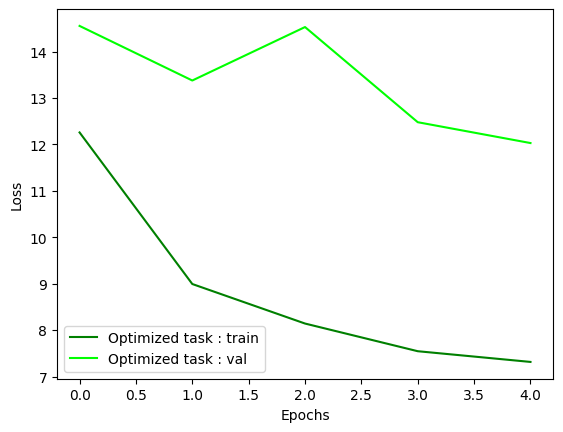

In [12]:
plot_losses(train_loss_hist, val_loss_hist)

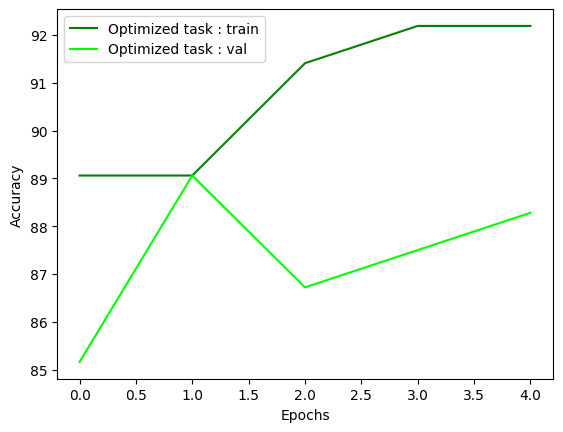

In [13]:
plot_accs(train_acc_hist, val_acc_hist)

## Save vanilla SNN

In [14]:
model_path = path + "\\SNN_LoRA/state_dict.pth"

In [15]:
save(model_path, snn_model)

## Load LoRA SNN

In [28]:
lora_rank = 4

In [29]:
lora_snn_model = LoRA_SNN(lora_rank, model_path, num_inputs, num_hidden, num_outputs, beta, batch_size, num_steps).to(device)

In [30]:
print("Number of none LoRA parameters of the linear layers (not trainable):", count_all_parameters(lora_snn_model))
print("Number of parameters introduced by LoRA (trainable):", count_lora_parameters(lora_snn_model))

Number of none LoRA parameters of the linear layers (not trainable): 790005
Number of parameters introduced by LoRA (trainable): 11156


## Test vanilla SNN

In [31]:
# So far, lora_snn_model is simply our trained vanilla SNN

In [32]:
print(f"vanilla SNN model achieves {test(lora_snn_model, test_loader_1, task_1, batch_size, device)}% accuracy on task 1")
print(f"vanilla SNN model achieves {test(lora_snn_model, test_loader_2, task_2, batch_size, device)}% accuracy on task 2")

vanilla SNN model achieves 88.48% accuracy on task 1
vanilla SNN model achieves 26.64% accuracy on task 2


## Train LoRA SNN on task 2

In [33]:
task = task_2
train_loader = train_loader_2
val_loader = val_loader_2
comp_val_loader = val_loader_1

In [34]:
optimizer = torch.optim.Adam(lora_snn_model.parameters(), lr=1e-4, betas=(0.9, 0.999))
num_epochs = 2

In [35]:
output = train(lora_snn_model, task, dtype, loss, optimizer, train_loader, val_loader, num_epochs, batch_size, num_steps, device, comp_val_loader=comp_val_loader)
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist, comp_val_loss_hist, comp_val_acc_hist = output

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

50 batches used in epoch 0
100 batches used in epoch 0
150 batches used in epoch 0


 50%|██████████████████████████████████████████                                          | 1/2 [00:29<00:29, 29.82s/it]

50 batches used in epoch 1
100 batches used in epoch 1
150 batches used in epoch 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:06<00:00, 33.38s/it]


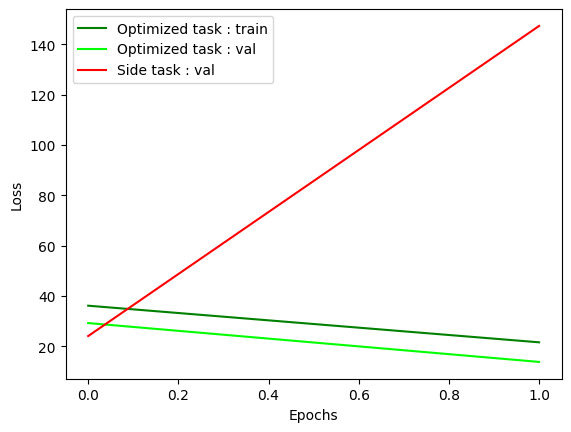

In [36]:
plot_losses(train_loss_hist, val_loss_hist, comp_val_loss_hist)

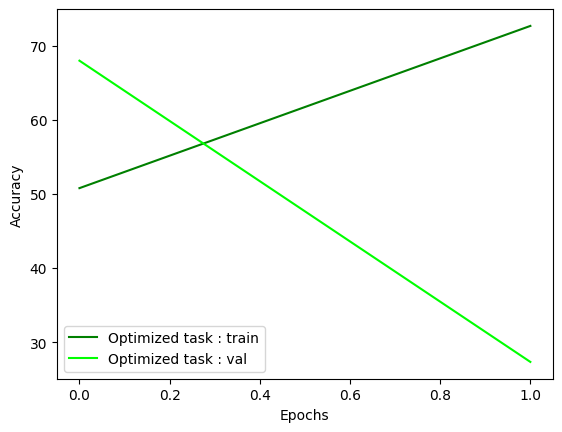

In [37]:
plot_accs(train_acc_hist, comp_val_acc_hist)

## Test LoRA SNN on both tasks

In [38]:
print(f"lora_snn_model achieve {test(lora_snn_model, test_loader_1, task_1, batch_size, device)}% accuracy on task 1")
print(f"lora_snn_model achieve {test(lora_snn_model, test_loader_2, task_2, batch_size, device)}% accuracy on task 2")

lora_snn_model achieve 27.72% accuracy on task 1
lora_snn_model achieve 72.82% accuracy on task 2
